### I did a whole bunch of cleaning and massaging here before going to SelectKBest, as you can see.  Still more could be done, namely converting object types (very likely just text) to numerics, but I finally let the dummy encoding take care of it.  In industry, I'll likely do some exploratory modeling and feature selection sooner, just to see how things go, then get more serious about data cleaning.
### As I mentioned in our call, I was surprised which features ended up being strongest; I was definitely looking at it as a human, and was way off.  Good lesson in trusting the technology, provided I do my end correctly.
### I'm not sure I could predict above 90% without using payment amt or outstanding principal, and would need to winnow them out to see.  Considering they're in the top 4, it would be difficult.  Regardless, Thinkful's estimate for this whole lesson, including this drill, is 2-3 hours, and I'm beyond double that already.  I know I could easily find out, now that my model is working well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, f_classif
%matplotlib inline

In [2]:
def cleanup(df, col, patterns):
    """ 
    Cleans up names in a specified dataframe.column, according to patterns
    Patterns are a tuple of lists: ([regex, replacement], [...], etc)
    replace() happens IN PLACE
    """
    for pattern, replacement in patterns:
        df[col] = df[col].str.replace(pattern, replacement)


In [3]:
y2015 = pd.read_csv('loans.csv', skipinitialspace=True, header=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# a bunch of cleanup here; I dropped NaN's, but only if a column had 200k or more
y2015 = y2015[:-2]
y2015.drop(columns=["id", "member_id"], inplace=True)
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc', "verification_status_joint",
            "disbursement_method", "hardship_type", "pymnt_plan", "title"], 1, inplace=True)

y2015["term"] = pd.to_numeric(y2015["term"].str.strip(' months'), errors='coerce')
y2015.dropna(axis=1, how='any', thresh=200000, inplace=True)

In [5]:
# changing the employment length column to numeric, "10+" becomes 11, 
# ""< 1" becomes 0, and none/0 becomes -1; removed "year/s"
patterns = ([r" years?", ""],
            [r"10", "11"],
            [r"< 1\b", "0"],
            [r"+", ""])

cleanup(y2015, "emp_length", patterns)
y2015["emp_length"] = y2015["emp_length"].fillna(-1)
y2015["emp_length"] = pd.to_numeric(y2015["emp_length"], errors='coerce')

In [6]:
y2015["emp_length"].value_counts()

 11    141521
 2      37497
 0      34340
 3      33430
 1      27473
 5      24930
 4      24506
-1      23817
 8      21560
 7      18414
 6      16838
 9      16769
Name: emp_length, dtype: int64

In [7]:
y2015.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,17475.0,17475.0,17475.0,36,13.99,597.17,C,2,RENT,39750.0,...,84.6,0.0,0.0,0.0,50240.0,32365.0,21000.0,29240.0,N,Y
1,16000.0,16000.0,16000.0,60,12.88,363.07,C,11,OWN,90000.0,...,86.7,25.0,0.0,0.0,263351.0,11594.0,16300.0,0.0,N,N
2,20000.0,20000.0,20000.0,36,5.32,602.30,A,9,OWN,65000.0,...,100.0,0.0,0.0,0.0,106217.0,15444.0,76200.0,30017.0,N,N
3,24000.0,24000.0,24000.0,60,9.80,507.58,B,-1,OWN,77900.0,...,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,N,N
4,18000.0,18000.0,18000.0,36,7.49,559.83,A,5,MORTGAGE,75000.0,...,97.8,50.0,0.0,0.0,335119.0,102660.0,20400.0,107522.0,N,N


In [8]:
# very computationally intensive, nested for loops! I had to
# see where I had duplicate columns, and there were a pair
cols = y2015.columns
for ct, col in enumerate(cols[:-1]):
    for name in cols[(ct + 1):]:
        if np.array_equal(y2015[col], y2015[name]):
            print(f"TRUE for {col, name}")

TRUE for ('loan_amnt', 'funded_amnt')


In [9]:
# these two columns are identical, making one extraneous
np.where(y2015["loan_amnt"] != y2015["funded_amnt"])
y2015.drop("funded_amnt", 1, inplace=True)

In [10]:
#y2015.info()

In [11]:
# I'm doing this to suppress a warning and keep cross-validation happy
# It was complaining about less than the number of folds in one of my classes
y2015.loc[y2015["loan_status"] == "Late (31-120 days)"].head(4)
y2015.loc[[52, 217, 307, 360], "loan_status"] = 'Default'
y2015["loan_status"].value_counts()

Fully Paid            273150
Charged Off            72363
Current                70663
Late (31-120 days)      2765
In Grace Period         1510
Late (16-30 days)        634
Default                   10
Name: loan_status, dtype: int64

### This is pretty useless, obviously need to narrow waaaayy down

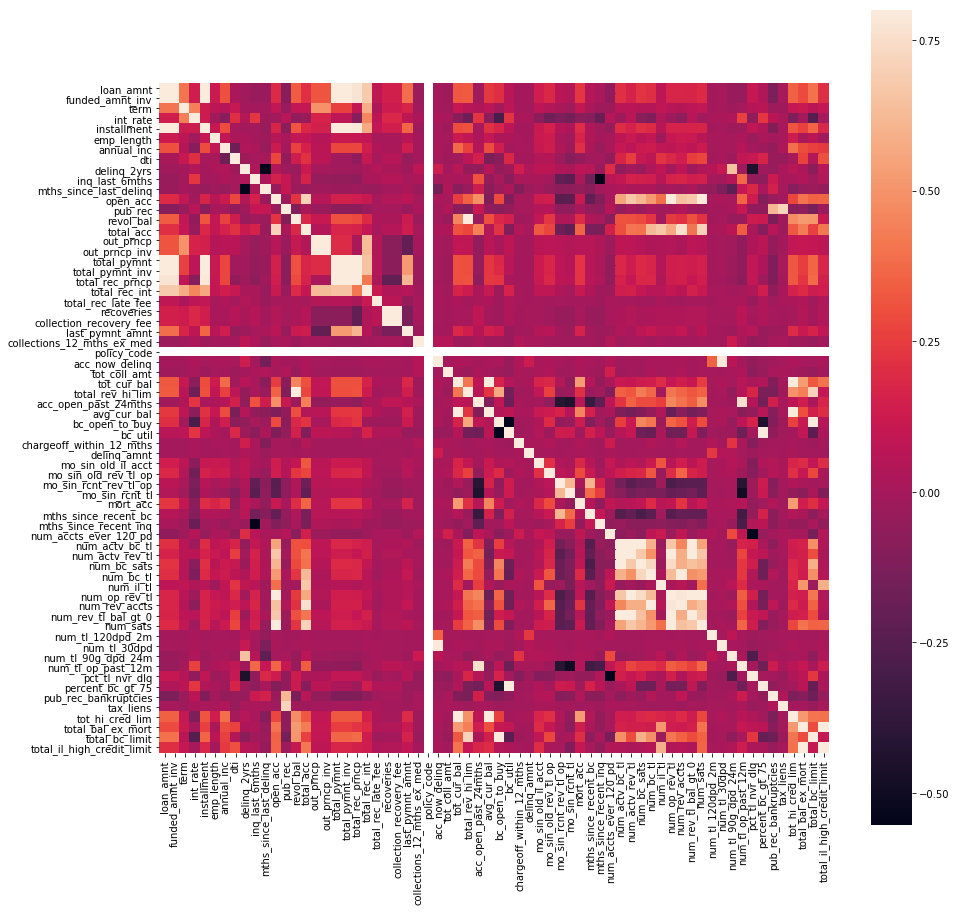

In [12]:
corrmat = y2015.corr()

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [13]:
# Just looking at these to see which are other than numeric
cats = list(y2015.select_dtypes(include=['object']).columns)
#cats.nunique()
cats.remove("loan_status")
cats

['grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [14]:
# just some setup, don't want our outcome in the dataset
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)

In [15]:
X = X.dropna(axis=1)

### SelectKBest is my friend.  I also did it without, but this is extremely helpful.

In [16]:
# yummy
X_new = SelectKBest(f_classif, k=10).fit_transform(X, Y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [24] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### I wanted to see what was actually being selected.  Notice 'k = 4', doesn't take a lot for good predictions.

In [17]:
selector = SelectKBest(f_classif, k = 4)
X_new_2 = selector.fit_transform(X, Y)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [24] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


              Feat_names       F_Scores
3  last_pymnt_d_Oct-2018  372050.874359
1          out_prncp_inv  106619.528786
0              out_prncp  106598.705946
2             recoveries   24576.260187


### Very very consistent predictions in cross-validation

In [18]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_new_2, Y, cv=10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

array([0.92702793, 0.92952128, 0.93104103, 0.9306578 , 0.93388587,
       0.93656787, 0.93644913, 0.93561793, 0.93514297, 0.93934644])

                       out_prncp  out_prncp_inv  recoveries  \
out_prncp               1.000000       0.999998   -0.084235   
out_prncp_inv           0.999998       1.000000   -0.084238   
recoveries             -0.084235      -0.084238    1.000000   
last_pymnt_d_Oct-2018   0.694056       0.694092   -0.114034   

                       last_pymnt_d_Oct-2018  
out_prncp                           0.694056  
out_prncp_inv                       0.694092  
recoveries                         -0.114034  
last_pymnt_d_Oct-2018               1.000000  


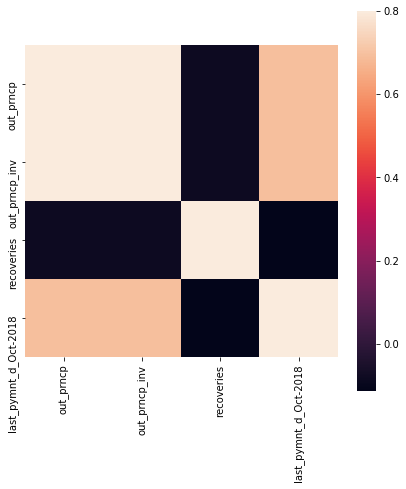

In [19]:
# With the simplified model...
corrmat = X[names].corr()
print(corrmat)

f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()